## Sveska za importovanje i pravljenje jobova za CAS-VIT mrežu

CAS-ViT se zasniva na Visual Transformer arhitekturi, više informacija na linku.

https://paperswithcode.com/paper/cas-vit-convolutional-additive-self-attention

(samo sam sortirao po broju parametara i uzeo ovu random mrezu, nemam pojma da li je dobra, i rad za sada ne razumem)

Ova sveska uz prateće fajlove automatski skida weightove za CAS-ViT model zadate veličine, i posle taj model šalje na AIHUB za testiranje.

Za sada sam pokrenuo samo xs model, koji se izvršava super brzo i ima manje parametara od MobileNetV2, doduše mnogo više layera koji su raspoređeni na više COMPUTE unita, što je koliko ja razumem dobro.

Ne znam da li je dobro da modele čuvamo na GIT-u (Drakula neka kaže kako bi to trebalo), pa sam sve fajlove koje se generišu stavio u gitignore.


In [1]:
import gdown
import torch
import rcvit
import torchsummary
import os
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)
from utils import helper, input_getter, qai_hub_jobs, tfhelper

import skimage as ski

/home/centar15-desktop1/LPCV_2025_T1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/centar15-desktop1/LPCV_2025_T1/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/centar15-desktop1/LPCV_2025_T1/.venv/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
2025-03-11 13:49:57.861248: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slight

In [2]:
# Model selection (options: "xs", "s", "m", "t")

modelID = "t"

driveFileIDs = dict()

driveFileIDs["xs"] = "16wKcwF6QMW5w_lyPYnDKjMNuoxQDfrLK"
driveFileIDs["s"]  = "1facFRq8s8oelYUtK1fj3fcfdoWoKDBQQ"
driveFileIDs["m"]  = "13sQpSEf0h_uuh0jRy9V0yIW6ZsbDpVGy"
driveFileIDs["t"]  = "1NqoIUPbwBC91RTjTUvubAbOfGqo1VYT0"

networks = dict()
networks["xs"] = rcvit.rcvit_xs
networks["s"]  = rcvit.rcvit_s
networks["m"]  = rcvit.rcvit_m
networks["t"]  = rcvit.rcvit_t

file_id = driveFileIDs[modelID]

modelName = "CASVIT_{}".format(modelID)

file_path = modelName + ".pth"

if not os.path.exists(file_path):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)
    print("Model downloaded successfully.")
else:
    print(f"File {file_path} already exists.")

File CASVIT_t.pth already exists.


In [3]:
net: rcvit.RCViT = networks[modelID]()
print(net)

RCViT(
  (patch_embed): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (network): ModuleList(
    (0): Sequential(
      (0): AdditiveBlock(
        (local_perception): LocalIntegration(
          (network): Sequential(
            (0): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
            (3): GELU(approximate='none')
            (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, aff

In [4]:
net = net.cuda()

net.eval()

torchsummary.summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,344
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              ReLU-3         [-1, 48, 112, 112]               0
            Conv2d-4           [-1, 96, 56, 56]          41,568
       BatchNorm2d-5           [-1, 96, 56, 56]             192
              ReLU-6           [-1, 96, 56, 56]               0
            Conv2d-7           [-1, 96, 56, 56]           9,312
       BatchNorm2d-8           [-1, 96, 56, 56]             192
            Conv2d-9           [-1, 96, 56, 56]             960
             GELU-10           [-1, 96, 56, 56]               0
           Conv2d-11           [-1, 96, 56, 56]           9,312
 LocalIntegration-12           [-1, 96, 56, 56]               0
      BatchNorm2d-13           [-1, 96, 56, 56]             192
           Conv2d-14          [-1, 288,

In [5]:
net.eval()
input = input_getter.local_image_getter('/home/centar15-desktop1/LPCV_2025_T1/datasets/imagenet/new_imgnet_coco/motorcycle/0000170548.jpeg')
net(torch.tensor(input.get_input_torch().cuda())).shape

FileNotFoundError: No such file: '/home/centar15-desktop1/LPCV_2025_T1/datasets/imagenet/new_imgnet_coco/motorcycle/0000170548.jpeg'

In [7]:
input.get_input_numpy().shape

(1, 3, 224, 224)

In [8]:
type(input.get_input_numpy())

numpy.ndarray

In [10]:
# Kada se uradi ovi jobovi na linkovima se moze naci vizuelizacija mreze i informacije za dalju analizu

compile, profile, inference = qai_hub_jobs.compile_profile_inference(net.cpu(), input)

Uploading tmpmph5i1pd.pt


100%|██████████| 84.6M/84.6M [00:04<00:00, 21.1MB/s]


Scheduled compile job (j5q0z4xop) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j5q0z4xop/

Waiting for compile job (j5q0z4xop) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
Scheduled profile job (jgl4owdm5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgl4owdm5/



Uploading dataset: 527kB [00:01, 346kB/s]                    <?, ?B/s]


Scheduled inference job (j562roxyg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j562roxyg/



In [6]:
if torch.cuda.is_available():
    print("using cuda")
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("using mps")
    device = torch.device("mps")
else:
    print("using cpu")
    device = torch.device("cpu")

idx = 0

using cuda
NVIDIA GeForce RTX 3050


In [7]:
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from dataset import DatasetReader
import matplotlib.pyplot as plt
import dataset.utils as utils
import time
import datetime
import os
import numpy as np

In [8]:

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    # transforms.RandomHorizontalFlip(p = 0.5),
    # transforms.ColorJitter(brightness = 0.5),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


In [24]:
dataset_coco = DatasetReader.COCODataset(annotation_file='../../datasets/coco/annotations/instances_train2017.json',
    image_dir= '../../datasets/coco/train2017',
    target_classes=[s.lower() for s in utils.GLOBAL_CLASSES],
    transform=transform)


root_folder = '../../datasets/imagenet/coco_80'
class_names = [s.lower().replace(' ', '_') for s in utils.GLOBAL_CLASSES]
dataset_imagenet = DatasetReader.CustomImageFolder(root_dir=root_folder, class_names=class_names, transform=transform)

dataset = torch.utils.data.ConcatDataset([dataset_coco, dataset_imagenet])

batch_size = 384
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=15, prefetch_factor=4, persistent_workers=True)

print(len(dataset))


672065


In [19]:


def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    start_datetime = datetime.datetime.now()
    os.mkdir(f'models/{start_datetime}')
    
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        for i, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
        asdf = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(dataloader):.4f}, Time: {asdf:.4f}s")
        if np.mod(epoch, 5) == 0:
            torch.save(model.state_dict(), f"models/{start_datetime}/model_{epoch}epoha_coco_train_batch_size_{batch_size}.pth")

In [ ]:
last_embed_dim = {"xs": 220, "s": 256, "m": 384, "t": 512}

net.dist = False
net.head = nn.Linear(last_embed_dim[modelID], 64) # 
net = net.cuda()

In [11]:
for name, param in net.named_parameters():
    param.requires_grad = False  # Freeze all layers

for param in net.head.parameters():
    param.requires_grad = True

In [16]:
wd = torch.load("CASVIT_t.pth")

net.load_state_dict(wd["model"])

<All keys matched successfully>

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00002)

train_model(net, dataloader, criterion, optimizer, 100)

Epoch [1/100], Step [10/1751], Loss: 4.2838
Epoch [1/100], Step [20/1751], Loss: 4.2698
Epoch [1/100], Step [30/1751], Loss: 4.2477
Epoch [1/100], Step [40/1751], Loss: 4.2738
Epoch [1/100], Step [50/1751], Loss: 4.2535
Epoch [1/100], Step [60/1751], Loss: 4.1810
Epoch [1/100], Step [70/1751], Loss: 4.2644
Epoch [1/100], Step [80/1751], Loss: 4.2376
Epoch [1/100], Step [90/1751], Loss: 4.2018
Epoch [1/100], Step [100/1751], Loss: 4.2471
Epoch [1/100], Step [110/1751], Loss: 4.1921
Epoch [1/100], Step [120/1751], Loss: 4.2083
Epoch [1/100], Step [130/1751], Loss: 4.2006
Epoch [1/100], Step [140/1751], Loss: 4.2023
Epoch [1/100], Step [150/1751], Loss: 4.1738
Epoch [1/100], Step [160/1751], Loss: 4.1929
Epoch [1/100], Step [170/1751], Loss: 4.1552
Epoch [1/100], Step [180/1751], Loss: 4.1591
Epoch [1/100], Step [190/1751], Loss: 4.1217
Epoch [1/100], Step [200/1751], Loss: 4.0791
Epoch [1/100], Step [210/1751], Loss: 4.1804
Epoch [1/100], Step [220/1751], Loss: 4.1522
Epoch [1/100], Step

KeyboardInterrupt: 

In [19]:
idx = 0

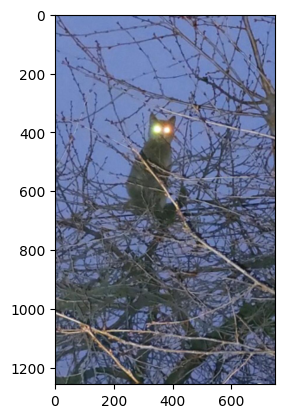

Top-10 predictions for V3_Small_trained on :
92 b'bee eater'          23.9%
374 b'langur'              6.3%
337 b'beaver'              5.9%
334 b'porcupine'           5.1%
21 b'kite'                4.7%
377 b'marmoset'            3.0%
82 b'ruffed grouse'       2.9%
379 b'howler monkey'       2.5%
380 b'titi'                2.1%
90 b'lorikeet'            2.0%


In [120]:
import matplotlib.pyplot as plt
import skimage as ski
from PIL import Image
from utils.helper import get_imagenet_categories


folderpath = "/home/centar15-desktop1/Desktop/example_data/images-20250210T115939Z-001/images/"

classes = get_imagenet_categories()

net = net.eval()

transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4435, 0.3968, 0.3221], std=[0.2266, 0.2126, 0.2013]),  
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.unsqueeze(0).to(device))
])

image = Image.open(folderpath + f"{idx}.jpg")

if image.mode == 'RGBA':
    # Convert the image to RGB (remove alpha channel)
    image = image.convert('RGB')

# image = ski.io.imread(folderpath + f"{idx}.jpg")

# print(image.shape)

# image = image[:,:, :3]
# image2 = np.transpose(image, (2, 0, 1))

# print(image.shape)

plt.imshow(image)
plt.show()

helper.print_probablities_from_output(net(transform2(image)), classes, 10, 'V3_Small_trained')

idx = idx + 1

In [132]:
totalPost = 0
accuracyPost = 0

net = net.eval()

dataset = DatasetReader.COCODataset(annotation_file='../../datasets/coco/annotations/instances_val2017.json',
    image_dir= '../../datasets/coco/val2017',
    target_classes=[s.lower() for s in utils.GLOBAL_CLASSES],
    transform=transform)

# batch_size = 256
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=11, prefetch_factor=4, persistent_workers=True)


for i in range(0, len(dataset)):
    totalPost += 1
    image, label = dataset[i]
    image = image.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    output = net(image)
    _, predicted = torch.max(output, 1)
    # print(f"Predicted: {predicted.item()}, Actual: {label.item()}")
    if(i % 1000 == 0):
        print(f"Slika: {i}")
    if predicted.item() == label.item():
        accuracyPost += 1
    

print(f"Accuracy: {accuracyPost/totalPost}")

Slika: 0
Slika: 1000
Slika: 2000
Slika: 3000
Slika: 4000
Slika: 5000
Slika: 6000
Slika: 7000
Slika: 8000
Slika: 9000
Slika: 10000
Slika: 11000
Slika: 12000
Slika: 13000
Slika: 14000
Slika: 15000
Slika: 16000
Slika: 17000
Slika: 18000
Slika: 19000
Slika: 20000
Slika: 21000
Slika: 22000
Slika: 23000
Accuracy: 0.5976218374343618
